In [45]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
cpu MHz		: 2200.000
cpu cores	: 1
# RAM
MemTotal:       13333596 kB
# GPU

# OS
Linux b28c317e0f49 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux


In [46]:
!pip install transformers

In [47]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *
from sklearn.model_selection import train_test_split

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

2.3.0


## Getting the data

In [48]:
# Load in the dataset
!git clone https://github.com/fowiny/humor_detection

Cloning into 'humor_detection'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (48/48), done.


In [50]:
%cd humor_detection/datasets
!ls

[Errno 2] No such file or directory: 'humor_detection/datasets'
/content/humor_detection/datasets/humor_detection/datasets
humorous_oneliners.pickle      reuters_headlines.pickle  wiki_sentences.pickle
oneliners_incl_doubles.pickle  stopwords.txt
proverbs.pickle		       train_humour.csv


# Choose model

In [53]:
from transformers import BertTokenizer, BertModel


MODEL_TYPE = 'bert-base-uncased'
MAX_SIZE = 200
BATCH_SIZE = 200

tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

#### 1. Read data and tokenizer

Read tokenizer and data, as well as defining the maximum sequence length that will be used for the input to Bert (maximum is usually 512 tokens)

In [52]:
HAS_ANS = False
training_sample_count = 1000 # 4000
training_epochs = 1 # 3
test_count = 1000
running_folds = 1 # 2
MAX_SEQUENCE_LENGTH = 200

### Humour dataset

In [54]:
df = pd.read_csv('train_humour.csv')
df.head(3)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4


In [15]:
X = df['text']
y = df['is_humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


#df_train = df[:training_sample_count*5]
df_train = pd.DataFrame({'text':X_train, 'is_humor':y_train})

#df_test = df[:test_count]
df_test = pd.DataFrame({'text':X_test, 'is_humor':y_test})

In [16]:
test_df_y = df_test.copy()
del df_test['is_humor']

df_sub = test_df_y.copy()

print(len(df),len(df_train),len(df_test))
display(df_train.head())
display(df_test.head())

8000 5360 2640


,text,is_humor
1194,"Peace be Still, is my prayer tonight. For all ...",0
7600,The human body is made up of 70% water... the ...,1
2885,My wife was a little puzzled when I suddenly b...,1
1756,"""Will you still love me when I'm no longer you...",0
497,don't make fun of anyone trying to better them...,0


,text
2215,If you are Asian in the kitchen and African in...
2582,Why is there only a stairway to heaven but a h...
1662,I once dated a girl with a twin People asked m...
3027,There are people out their happier with less t...
4343,"One zebra says to the other, ""I'm going to che..."


In [17]:
print(list(df_train.columns))

['text', 'is_humor']


In [18]:
output_categories = list(df_train.columns[[1]])
input_categories = list(df_train.columns[[0]])

if HAS_ANS:
    output_categories = list(df_train.columns[11:])
    input_categories = list(df_train.columns[[1,2,5]])
    

TARGET_COUNT = len(output_categories)

print('\ninput categories:\n\t', input_categories)
print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)
print('\noutput categories:\n\t', output_categories)


input categories:
	 ['text']

output TARGET_COUNT:
	 1

output categories:
	 ['is_humor']


#### 2. Preprocessing functions

These are some functions that will be used to preprocess the raw text data into useable Bert inputs.<br>

*update 4:* credits to [Minh](https://www.kaggle.com/dathudeptrai) for this implementation. If I'm not mistaken, it could be used directly with other Huggingface transformers too! Note that due to the 2 x 512 input, it will require significantly more memory when finetuning BERT.

In [19]:
def _convert_to_transformer_inputs(title, question, answer, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    
    def return_id(str1, str2, truncation_strategy, length):

        inputs = tokenizer.encode_plus(str1, str2,
            add_special_tokens=True,
            max_length=length,
            truncation_strategy=truncation_strategy)
        
        input_ids =  inputs["input_ids"]
        input_masks = [1] * len(input_ids)
        input_segments = inputs["token_type_ids"]
        padding_length = length - len(input_ids)
        padding_id = tokenizer.pad_token_id
        input_ids = input_ids + ([padding_id] * padding_length)
        input_masks = input_masks + ([0] * padding_length)
        input_segments = input_segments + ([0] * padding_length)
        
        return [input_ids, input_masks, input_segments]
    
    input_ids_q, input_masks_q, input_segments_q = return_id(
        title, None, 'longest_first', max_sequence_length)
    
    input_ids_a, input_masks_a, input_segments_a = return_id(
        '', None, 'longest_first', max_sequence_length)
        
    return [input_ids_q, input_masks_q, input_segments_q,
            input_ids_a, input_masks_a, input_segments_a]

def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    input_ids_q, input_masks_q, input_segments_q = [], [], []
    input_ids_a, input_masks_a, input_segments_a = [], [], []
    for _, instance in tqdm(df[columns].iterrows()):
        t, q, a = instance.text, instance.text, instance.text

        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = \
        _convert_to_transformer_inputs(t, q, a, tokenizer, max_sequence_length)
        
        input_ids_q.append(ids_q)
        input_masks_q.append(masks_q)
        input_segments_q.append(segments_q)
        input_ids_a.append(ids_a)
        input_masks_a.append(masks_a)
        input_segments_a.append(segments_a)
        
    return [np.asarray(input_ids_q, dtype=np.int32), 
            np.asarray(input_masks_q, dtype=np.int32), 
            np.asarray(input_segments_q, dtype=np.int32),
            np.asarray(input_ids_a, dtype=np.int32), 
            np.asarray(input_masks_a, dtype=np.int32), 
            np.asarray(input_segments_a, dtype=np.int32)]

def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

In [20]:
outputs = compute_output_arrays(df_train, output_categories)
inputs = compute_input_arrays(df_train, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## 3. Create model

~~`compute_spearmanr()`~~ `mean_squared_error` is used to compute the competition metric for the validation set
<br><br>
`create_model()` contains the actual architecture that will be used to finetune BERT to our dataset.


In [21]:
def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

def create_model():
    q_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    q_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig() # print(config) to see settings
    config.output_hidden_states = False # Set to True to obtain hidden states
    # caution: when using e.g. XLNet, XLNetConfig() will automatically use xlnet-large config
    
    bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
    
    # if config.output_hidden_states = True, obtain hidden states via bert_model(...)[-1]
    q_embedding = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
    a_embedding = bert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    
    q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    
#     x = tf.keras.layers.Concatenate()([q, q])
    
    x = tf.keras.layers.Dropout(0.2)(q)
    
    x = tf.keras.layers.Dense(TARGET_COUNT, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[q_id, q_mask, q_atn, ], outputs=x)
    
    return model

#### 4. Obtain inputs and targets, as well as the indices of the train/validation splits

In [22]:
output_categories

['is_humor']

## 5. Training, validation and testing

Loops over the folds in gkf and trains each fold for 3 epochs --- with a learning rate of 3e-5 and batch_size of 6. A simple binary crossentropy is used as the objective-/loss-function. 

In [25]:
# Evaluation Metrics
import sklearn
def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):
    print('==================', label2)
    ### For regression
    if is_regression:
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('Root mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred, squared = False))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred, squared = False)
    else:
        ### FOR Classification
        print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
        print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
        print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
        print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)
        return sklearn.metrics.accuracy_score(y_true, y_pred)

print_evaluation_metrics([1,0], [0.9,0.1], '', True)
print_evaluation_metrics([1,0], [1,1], '', False)

mean_absolute_error  : 0.09999999999999999
Root mean_squared_error  : 0.09999999999999999
r2 score  : 0.96
balanced_accuracy_score  : 0.5
average_precision_score  : 0.5
balanced_accuracy_score  : 0.5
accuracy_score  : 0.5
f1_score  : 0.6666666666666666
[[0 1]
 [0 1]]
Acc 0.5 Prec 0.5 Rec 1.0 F1 0.6666666666666666


0.5

### Loss function selection
Regression problem between 0 and 1, so binary_crossentropy and mean_absolute_error seem good.

Here are the explanations: https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

In [26]:
min_acc = 1000000
min_test = []
valid_preds = []
test_preds = []
best_model = False
for LR in np.arange(1e-5, 2e-5, 3e-5).tolist():
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('LR=', LR)
    gkf = GroupKFold(n_splits=5).split(X=df_train.text, groups=df_train.text)

    for fold, (train_idx, valid_idx) in enumerate(gkf):
        if fold not in range(running_folds):
            continue
        train_inputs = [(inputs[i][train_idx])[:training_sample_count] for i in range(len(inputs))]
        train_outputs = (outputs[train_idx])[:training_sample_count]

        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]

        print(np.array(train_inputs).shape, np.array(train_outputs).shape)
#         print(train_idx[:10], valid_idx[:10])

        K.clear_session()
        model = create_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        for xx in range(1):
            model.fit(train_inputs, train_outputs, epochs=training_epochs, batch_size=6)
            # model.save_weights(f'bert-{fold}.h5')
            valid_preds.append(model.predict(valid_inputs))
            #rho_val = compute_spearmanr_ignore_nan(valid_outputs, valid_preds[-1])
            #print('validation score = ', rho_val)
            acc = print_evaluation_metrics(np.array(valid_outputs), np.array(valid_preds[-1]), 'on #'+str(xx+1))
            if acc < min_acc:
                print('new acc >> ', acc)
                min_acc = acc
                best_model = model
#                 min_test = model.predict(test_inputs)
#                 test_preds.append(min_test)
            print(' ')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LR= 1e-05
(6, 1000, 200) (1000, 1)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config o

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


167/167 [==============================] - 48s 290ms/step - loss: 0.4228


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


mean_absolute_error on #1 : 0.1310938389384563
Root mean_squared_error on #1 : 0.2629552100866898
r2 score on #1 : 0.7034766817523803
new acc >>  0.2629552100866898
 


In [30]:
print('best acc >> ', acc)

best acc >>  0.2629552100866898


In [31]:
len(valid_inputs[0])

1072

In [32]:
print(valid_outputs.shape, valid_preds[-1].shape)
print_evaluation_metrics(np.array(valid_outputs), np.array(valid_preds[-1]), '')

(1072, 1) (1072, 1)
mean_absolute_error  : 0.1310938389384563
Root mean_squared_error  : 0.2629552100866898
r2 score  : 0.7034766817523803


0.2629552100866898

In [33]:
# %%time
min_test = best_model.predict(test_inputs)

## use min_test
# min_test

In [62]:
min_test

array([[0.9963403 ],
       [0.93965083],
       [0.99499077],
       ...,
       [0.03540738],
       [0.24878044],
       [0.88893956]], dtype=float32)

In [34]:
df_test.to_csv('df_test.csv')
test_df_y.to_csv('test_df_y.csv')


## Regression submission

In [35]:
df_sub.head()

,text,is_humor
2215,If you are Asian in the kitchen and African in...,1
2582,Why is there only a stairway to heaven but a h...,1
1662,I once dated a girl with a twin People asked m...,1
3027,There are people out their happier with less t...,0
4343,"One zebra says to the other, ""I'm going to che...",1


In [37]:
df_sub = test_df_y.copy()
# df_sub['pred'] = np.average(test_preds, axis=0) # for weighted average set weights=[...]
df_sub['pred'] = min_test


print_evaluation_metrics(df_sub['is_humor'], df_sub['pred'], '', True)


df_sub.to_csv('sub1.csv', index=False)
df_sub.head()

mean_absolute_error  : 0.13133173579875745
Root mean_squared_error  : 0.2582869504543274
r2 score  : 0.717786444665116


,text,is_humor,pred
2215,If you are Asian in the kitchen and African in...,1,0.996340
2582,Why is there only a stairway to heaven but a h...,1,0.939651
1662,I once dated a girl with a twin People asked m...,1,0.994991
3027,There are people out their happier with less t...,0,0.271396
4343,"One zebra says to the other, ""I'm going to che...",1,0.978390


## Binary submission

In [38]:
for split in np.arange(0.1, 0.99, 0.1).tolist():
    df_sub['pred_bi'] = (df_sub['pred'] > split)

    print_evaluation_metrics(df_sub['is_humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

    df_sub.to_csv('sub3.csv', index=False)
    df_sub.head()

================== SPLIT on 0.1
balanced_accuracy_score  : 0.793745326354022
average_precision_score  : 0.7962969116473558
balanced_accuracy_score  : 0.793745326354022
accuracy_score  : 0.8401515151515152
f1_score  : 0.8845101258894362
[[ 602  410]
 [  12 1616]]
Acc 0.8401515151515152 Prec 0.7976307996051333 Rec 0.9926289926289926 F1 0.8845101258894362
================== SPLIT on 0.2
balanced_accuracy_score  : 0.8471450699711569
average_precision_score  : 0.8421600830594976
balanced_accuracy_score  : 0.8471450699711569
accuracy_score  : 0.8776515151515152
f1_score  : 0.9078984887368121
[[ 725  287]
 [  36 1592]]
Acc 0.8776515151515152 Prec 0.8472591804151144 Rec 0.9778869778869779 F1 0.9078984887368121
================== SPLIT on 0.30000000000000004
balanced_accuracy_score  : 0.8756543104369192
average_precision_score  : 0.8699595870840265
balanced_accuracy_score  : 0.8756543104369192
accuracy_score  : 0.8962121212121212
f1_score  : 0.9196951934349356
[[ 797  215]
 [  59 1569]]
Acc 0.8

In [65]:
df_sub['pred_bi'] = (df_sub['pred'] > 0.5)
print_evaluation_metrics(df_sub['is_humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

df_sub.to_csv('sub3.csv', index=False)
df_sub.head()

================== SPLIT on 0.9
balanced_accuracy_score  : 0.9021605597692555
average_precision_score  : 0.9000860284088132
balanced_accuracy_score  : 0.9021605597692555
accuracy_score  : 0.9102272727272728
f1_score  : 0.9278977791299057
[[ 878  134]
 [ 103 1525]]
Acc 0.9102272727272728 Prec 0.9192284508740205 Rec 0.9367321867321867 F1 0.9278977791299057


,text,is_humor,pred,pred_bi
2215,If you are Asian in the kitchen and African in...,1,0.996340,True
2582,Why is there only a stairway to heaven but a h...,1,0.939651,True
1662,I once dated a girl with a twin People asked m...,1,0.994991,True
3027,There are people out their happier with less t...,0,0.271396,False
4343,"One zebra says to the other, ""I'm going to che...",1,0.978390,True


In [63]:
df_sub.head()

,text,is_humor,pred,pred_bi
2215,If you are Asian in the kitchen and African in...,1,0.996340,True
2582,Why is there only a stairway to heaven but a h...,1,0.939651,True
1662,I once dated a girl with a twin People asked m...,1,0.994991,True
3027,There are people out their happier with less t...,0,0.271396,False
4343,"One zebra says to the other, ""I'm going to che...",1,0.978390,True


,text,is_humor,pred,pred_bi
142,Grapes don't cry when they're crushed But they...,1,0.529787,False
1490,What do you call a participation trophy in ast...,1,0.970206,True
6343,Avocados have more carotenoid lutein than any ...,0,0.035407,False
6721,13 Always have time for your girl. If you dont...,0,0.248780,False
2004,"In 2017, police in the German city of Frankfur...",1,0.888940,False


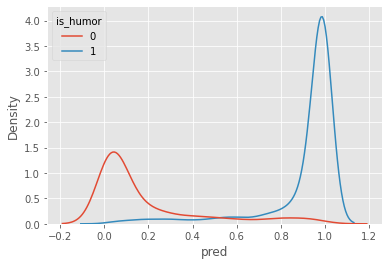

In [67]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns



sns.kdeplot(df_sub.pred,hue=df_sub.is_humor)